In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
import keras

Using TensorFlow backend.


In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [4]:
#read data from csv file
dat=pd.read_csv('Book3.csv')
print(dat.head())

                    Date  Hour  DryBulb  DewPnt  SYSLoad   NumDate
0  2004-01-01 00:00:00.0     1       37      25    12230  732000.0
1  2004-01-01 00:00:00.0     2       37      25    11534  732000.0
2  2004-01-01 00:00:00.0     3       39      24    11038  732000.0
3  2004-01-01 00:00:00.0     4       38      22    10777  732000.0
4  2004-01-01 00:00:00.0     5       37      20    10764  732000.0


In [5]:
hdata=pd.read_excel('Holidays.xls')
hdata.dtypes

Date       datetime64[ns]
Holiday            object
dtype: object

In [6]:
holidays=hdata.Date
holidays.head()

0   2004-01-01
1   2004-01-19
2   2004-02-16
3   2004-05-31
4   2004-07-05
Name: Date, dtype: datetime64[ns]

In [7]:
dat['Date']=pd.to_datetime(dat['Date'])
dat.dtypes

Date       datetime64[ns]
Hour                int64
DryBulb             int64
DewPnt              int64
SYSLoad             int64
NumDate           float64
dtype: object

In [8]:
dayofweek=dat.Date.dt.weekday
dayofweek.head()

0    3
1    3
2    3
3    3
4    3
Name: Date, dtype: int64

In [9]:
isworkday = np.in1d(dayofweek,[0,1,2,3,4]) & ~np.in1d(dat['Date'],holidays)
isworkday[22]

False

In [10]:
import scipy
import scipy.signal
#By using the lfilter method get the previous 24 hour averrage temperature 
prev24houravg = scipy.signal.lfilter(np.ones(24) / 24, 1, dat['SYSLoad'])
prev24houravg.shape

(52608,)

In [11]:
prevweeksamehour=np.hstack(((np.ones(168)*-1),(dat['SYSLoad'][0:-168])))
prevweeksamehour.shape

(52608,)

In [12]:
prevdaysamehour=np.hstack(((np.ones(24)*-1),(dat['SYSLoad'][0:-24])))
prevdaysamehour[0]

-1.0

In [13]:
#organize data into the 8 inputs
X = np.vstack((dat['DryBulb'],dat['DewPnt'],dat['Hour'],dayofweek,isworkday,prevweeksamehour,prevdaysamehour,prev24houravg))
X=np.transpose(X)
X.shape

(52608, 8)

In [14]:
# split the inputs into training, validation and tests sets
def split_inputs(data):
    trainInd = dat.Date < dt.datetime(2008, 1, 1) 
    train_x = data[trainInd,:]
    #get rid of the first 168 rows because one of the columns has null values
    train_x= train_x[168:,:]
    
    valid_x=data[35064:43848]
    
    testInd = dat.Date>= dt.datetime(2009, 1, 1)
    test_x=data[testInd,:]
    
    return train_x, valid_x, test_x

In [15]:
train_x, valid_x, test_x = split_inputs(X)
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

(34896, 8)
(8784, 8)
(8760, 8)


In [16]:
# organize the inputs of the network such that each input is 2 dimensions of size n_rowsx8 
def organize_inputs(data, n_rows):


    X = list()
    start = 0
    # organize each input in the set 
    for _ in range(len(data)):
        #define the last row of the input
        end = start + n_rows
        # check that we havent reached the end of the dataset
        if end <= len(data):
            X.append(data[start:end, 0:8])
    
        # move to next input
        start += 1    
        
    return np.array(X)

In [17]:
#define the number of timesteps or rows that will be in each input
n_rows=24
train_x = organize_inputs(train_x,n_rows)
valid_x = organize_inputs(valid_x,n_rows)
test_x = organize_inputs(test_x,n_rows)
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

(34873, 24, 8)
(8761, 24, 8)
(8737, 24, 8)


In [18]:
def split_outputs(outputs, n_rows):
    trainInd =dat.Date< dt.datetime(2008, 1, 1)
    trainY=outputs[trainInd]
    trainY=trainY[167+n_rows:]
    trainY=trainY.as_matrix(columns=None)
    trainY = trainY.reshape((trainY.shape[0], 1))
    
    validY=outputs[35087:43848]
    validY=validY.as_matrix(columns=None)
    validY = validY.reshape((validY.shape[0], 1))
    
    testInd = dat.Date>=dt.datetime(2009, 1, 1)
    testY = outputs[testInd]
    testY= testY[n_rows-1:]
    testY = testY.as_matrix(columns=None)
    testY=testY.reshape((testY.shape[0],1))
    
    return trainY, validY, testY

In [19]:
trainY, validY, testY= split_outputs(dat['SYSLoad'],n_rows)


C:\Users\afzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\afzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\afzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [28]:
period=6
n_hours=24
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(n_hours,8)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')

ValueError: Input 0 is incompatible with layer conv2d_2: expected ndim=4, found ndim=3

In [ ]:
import time
start_time = time.time()
train_x = train_x.reshape((train_x.shape[0],train_x.shape[1],train_x.shape[2]))
model.fit(train_x, trainY, batch_size=120, epochs=55, verbose=1)
time.time() - start_time

In [ ]:
validpredictions=model.predict(valid_x)
error=validY-validpredictions
mae=np.mean(np.absolute(error))
mae

In [49]:
errorpercent=np.absolute(error)/validY
mape=np.mean(errorpercent)*100
mape

1.9304508079748945

In [50]:
testpredictions=model.predict(test_x)
error=testY-testpredictions
mae=np.mean(np.absolute(error))
mae

263.3993540402884

In [51]:
errorpercent=np.absolute(error)/testY
mape=np.mean(errorpercent)*100
mape

1.9188162452375854

0
1
(1, 24, 8)
(1000, 24, 8)
1023
(2000, 24, 8)
2023
(3000, 24, 8)
3023
(4000, 24, 8)
4023
4359
[[ 1.50000000e+01  0.00000000e+00  1.00000000e+00  3.00000000e+00
   1.00000000e+00  1.22300000e+04  1.34150000e+04  1.72234167e+04]
 [ 1.40000000e+01  1.00000000e+00  2.00000000e+00  3.00000000e+00
   1.00000000e+00  1.15340000e+04  1.29900000e+04  1.72553750e+04]
 [ 1.30000000e+01  0.00000000e+00  3.00000000e+00  3.00000000e+00
   1.00000000e+00  1.10380000e+04  1.28320000e+04  1.72870833e+04]
 [ 1.20000000e+01 -1.00000000e+00  4.00000000e+00  3.00000000e+00
   1.00000000e+00  1.07770000e+04  1.28660000e+04  1.73181667e+04]
 [ 1.10000000e+01 -2.00000000e+00  5.00000000e+00  3.00000000e+00
   1.00000000e+00  1.07640000e+04  1.32330000e+04  1.73485833e+04]
 [ 1.10000000e+01 -4.00000000e+00  6.00000000e+00  3.00000000e+00
   1.00000000e+00  1.10320000e+04  1.44950000e+04  1.73762083e+04]
 [ 1.00000000e+01 -5.00000000e+00  7.00000000e+00  3.00000000e+00
   1.00000000e+00  1.15080000e+04  1.685

Epoch 55/60
4359/4359 [==============================] - 0s 77us/step - loss: 685129.1096
Epoch 56/60
4359/4359 [==============================] - 0s 79us/step - loss: 682235.5826
Epoch 57/60
4359/4359 [==============================] - 0s 78us/step - loss: 685460.7478
Epoch 58/60
4359/4359 [==============================] - 0s 78us/step - loss: 655062.9611
Epoch 59/60
4359/4359 [==============================] - 0s 76us/step - loss: 682087.3079
Epoch 60/60
4359/4359 [==============================] - 0s 79us/step - loss: 736929.2706
0
2
(1, 24, 8)
(641, 24, 8)
5023
(1641, 24, 8)
6023
(2641, 24, 8)
7023
(3641, 24, 8)
8023
8718
[[7.90000000e+01 5.80000000e+01 1.60000000e+01 2.00000000e+00
  1.00000000e+00 1.89820000e+04 1.94850000e+04 1.63790417e+04]
 [7.80000000e+01 5.80000000e+01 1.70000000e+01 2.00000000e+00
  1.00000000e+00 1.89080000e+04 1.94060000e+04 1.64102917e+04]
 [7.80000000e+01 5.90000000e+01 1.80000000e+01 2.00000000e+00
  1.00000000e+00 1.86870000e+04 1.91450000e+04 1.6441

4359/4359 [==============================] - 0s 87us/step - loss: 385451.7836
Epoch 48/60
4359/4359 [==============================] - 0s 80us/step - loss: 380166.7488
Epoch 49/60
4359/4359 [==============================] - 0s 80us/step - loss: 402465.5685
Epoch 50/60
4359/4359 [==============================] - 0s 81us/step - loss: 345287.4216
Epoch 51/60
4359/4359 [==============================] - 0s 82us/step - loss: 355607.3775
Epoch 52/60
4359/4359 [==============================] - 0s 81us/step - loss: 398341.3759
Epoch 53/60
4359/4359 [==============================] - 0s 81us/step - loss: 349606.4256
Epoch 54/60
4359/4359 [==============================] - 0s 82us/step - loss: 337983.3661
Epoch 55/60
4359/4359 [==============================] - 0s 80us/step - loss: 373864.1407
Epoch 56/60
4359/4359 [==============================] - 0s 83us/step - loss: 416843.3471
Epoch 57/60
4359/4359 [==============================] - 0s 83us/step - loss: 357651.3125
Epoch 58/60
4359/4359 

4359/4359 [==============================] - 0s 91us/step - loss: 173684.1417
Epoch 40/60
4359/4359 [==============================] - 0s 84us/step - loss: 168119.6094
Epoch 41/60
4359/4359 [==============================] - 0s 86us/step - loss: 157490.3865
Epoch 42/60
4359/4359 [==============================] - 0s 91us/step - loss: 155279.6314
Epoch 43/60
4359/4359 [==============================] - 0s 88us/step - loss: 161750.6163
Epoch 44/60
4359/4359 [==============================] - 0s 87us/step - loss: 160024.3524
Epoch 45/60
4359/4359 [==============================] - 0s 88us/step - loss: 157565.1300
Epoch 46/60
4359/4359 [==============================] - 0s 88us/step - loss: 175361.7429
Epoch 47/60
4359/4359 [==============================] - 0s 89us/step - loss: 169787.3011
Epoch 48/60
4359/4359 [==============================] - 0s 87us/step - loss: 180334.3979
Epoch 49/60
4359/4359 [==============================] - 0s 85us/step - loss: 164791.0733
Epoch 50/60
4359/4359 

4359/4359 [==============================] - 0s 93us/step - loss: 129319.1543
Epoch 32/60
4359/4359 [==============================] - 0s 91us/step - loss: 135473.7602
Epoch 33/60
4359/4359 [==============================] - 0s 105us/step - loss: 113546.7613
Epoch 34/60
4359/4359 [==============================] - 0s 107us/step - loss: 121910.6845
Epoch 35/60
4359/4359 [==============================] - 0s 92us/step - loss: 115094.3620
Epoch 36/60
4359/4359 [==============================] - 0s 107us/step - loss: 113444.8416
Epoch 37/60
4359/4359 [==============================] - 0s 103us/step - loss: 113914.8874
Epoch 38/60
4359/4359 [==============================] - 0s 92us/step - loss: 110252.9604
Epoch 39/60
4359/4359 [==============================] - 0s 92us/step - loss: 109355.8670
Epoch 40/60
4359/4359 [==============================] - 0s 92us/step - loss: 110980.9261
Epoch 41/60
4359/4359 [==============================] - 0s 92us/step - loss: 118251.1426
Epoch 42/60
4359/4

253.3254120349884

NameError: name 'testY' is not defined

8744
34873
1
(1, 24, 8)
(127, 24, 8)
35023
(1127, 24, 8)
36023
(2127, 24, 8)
37023
(3127, 24, 8)
38023
(4127, 24, 8)
39023
39258
[[3.30000000e+01 3.10000000e+01 2.00000000e+00 0.00000000e+00
  1.00000000e+00 1.07520000e+04 1.16700000e+04 1.41909167e+04]
 [3.30000000e+01 3.10000000e+01 3.00000000e+00 0.00000000e+00
  1.00000000e+00 1.05370000e+04 1.13940000e+04 1.41953750e+04]
 [3.30000000e+01 3.10000000e+01 4.00000000e+00 0.00000000e+00
  1.00000000e+00 1.04800000e+04 1.11540000e+04 1.42102083e+04]
 [3.30000000e+01 3.10000000e+01 5.00000000e+00 0.00000000e+00
  1.00000000e+00 1.07530000e+04 1.11550000e+04 1.42443750e+04]
 [3.30000000e+01 3.10000000e+01 6.00000000e+00 0.00000000e+00
  1.00000000e+00 1.16090000e+04 1.15990000e+04 1.42853750e+04]
 [3.20000000e+01 3.00000000e+01 7.00000000e+00 0.00000000e+00
  1.00000000e+00 1.27860000e+04 1.22120000e+04 1.43474167e+04]
 [3.20000000e+01 3.00000000e+01 8.00000000e+00 0.00000000e+00
  1.00000000e+00 1.39180000e+04 1.28250000e+04 1.44204583e+

(972, 24, 8)
49023
(1972, 24, 8)
50023
(2972, 24, 8)
51023
(3972, 24, 8)
52023
52413
[[6.10000000e+01 6.00000000e+01 5.00000000e+00 2.00000000e+00
  1.00000000e+00 1.05350000e+04 1.08630000e+04 1.51726250e+04]
 [6.10000000e+01 6.00000000e+01 6.00000000e+00 2.00000000e+00
  1.00000000e+00 1.12670000e+04 1.14570000e+04 1.51725000e+04]
 [6.10000000e+01 6.00000000e+01 7.00000000e+00 2.00000000e+00
  1.00000000e+00 1.28570000e+04 1.29270000e+04 1.51727917e+04]
 [6.20000000e+01 6.10000000e+01 8.00000000e+00 2.00000000e+00
  1.00000000e+00 1.45340000e+04 1.47040000e+04 1.51691250e+04]
 [6.20000000e+01 6.00000000e+01 9.00000000e+00 2.00000000e+00
  1.00000000e+00 1.55490000e+04 1.57680000e+04 1.51664583e+04]
 [6.30000000e+01 6.10000000e+01 1.00000000e+01 2.00000000e+00
  1.00000000e+00 1.61610000e+04 1.65550000e+04 1.51610000e+04]
 [6.40000000e+01 6.20000000e+01 1.10000000e+01 2.00000000e+00
  1.00000000e+00 1.66610000e+04 1.72140000e+04 1.51523750e+04]
 [6.60000000e+01 6.20000000e+01 1.200000

In [168]:
ar

[1.182,
 1.9633057081339815,
 1.8033053599661446,
 1.7574217389443179,
 1.6938014966694563,
 1.8732578667334945,
 1.877581772168278,
 2.5208501705235515,
 1.6914175436614012,
 2.37086926869964,
 1.9312196283272482,
 2.978181169970406,
 1.648401852059553]

In [30]:
print(_____)

NameError: name '_____' is not defined

In [44]:
ar

[[1.182,
  1.9633057081339815,
  1.8033053599661446,
  1.7574217389443179,
  1.6938014966694563,
  1.8732578667334945,
  1.877581772168278,
  2.5208501705235515,
  1.6914175436614012,
  2.37086926869964,
  1.9312196283272482,
  2.978181169970406,
  1.648401852059553],
 1.166025118137716,
 1.08]

In [49]:
ar.size

AttributeError: 'list' object has no attribute 'size'

In [45]:
ar=[1.182,
 1.9633057081339815,
 1.8033053599661446,
 1.7574217389443179,
 1.6938014966694563,
 1.8732578667334945,
 1.877581772168278,
 2.5208501705235515,
 1.6914175436614012,
 2.37086926869964,
 1.9312196283272482,
 2.978181169970406,
 1.648401852059553,
 1.4307124617910796,
 1.203,
 0.99,
 1.5,
 1.5,
 1.7,
 1.08,
 1.166025118137716]

In [116]:
ar

[1.182,
 1.5633057081339814,
 1.4033053599661445,
 1.3574217389443177,
 1.2938014966694564,
 1.4732578667334946,
 1.477581772168278,
 1.5312196283272481,
 2.578181169970406,
 1.248401852059553,
 1.4307124617910796,
 1.203,
 0.99,
 1.5,
 1.5,
 1.7,
 1.08,
 1.166025118137716,
 1.2375712069424116,
 1.4706359883111715,
 2.2288272653371664,
 1.3690877014721907,
 0.7254199229458037,
 1.3277337956123798,
 1.6488255275282317]

In [128]:
ar

[[1.182,
  1.5633057081339814,
  1.4033053599661445,
  1.3574217389443177,
  1.2938014966694564,
  1.4732578667334946,
  1.477581772168278,
  1.5312196283272481,
  2.578181169970406,
  1.248401852059553,
  1.4307124617910796,
  1.203,
  0.99,
  1.5,
  1.5,
  1.7,
  1.08,
  1.166025118137716,
  1.2375712069424116,
  1.4706359883111715,
  2.2288272653371664,
  1.3690877014721907,
  0.7254199229458037,
  1.3277337956123798,
  1.6488255275282317,
  1.182,
  1.5633057081339814,
  1.4033053599661445,
  1.3574217389443177,
  1.2938014966694564,
  1.4732578667334946,
  1.477581772168278,
  1.5312196283272481,
  2.578181169970406,
  1.248401852059553,
  1.4307124617910796,
  1.203,
  0.99,
  1.5,
  1.5,
  1.7,
  1.08,
  1.166025118137716,
  1.2375712069424116,
  1.4706359883111715,
  2.2288272653371664,
  1.3690877014721907,
  0.7254199229458037,
  1.3277337956123798,
  1.6488255275282317]]

In [100]:
sum(ar)/len(ar)

1.5714526232420412

In [14]:
ar1=[1.907538516034726,
 1.213958126837731,
 1.799972938800585,
 1.4480962908262376,
 1.2703184407700367]

In [16]:
ar2=[1.1539805393249483,
 2.2512024719808976,
 2.2512024719808976,
 1.2252441089977366,
 1.8411824156211045]

In [6]:
ar=[1.182423142142142,
  1.5633057081339814,
  1.4033053599661445,
  1.3574217389443177,
  1.2938014966694564,
  1.4732578667334946,
  1.477581772168278,
  1.5312196283272481,
  2.578181169970406,
  1.248401852059553,
  1.4307124617910796,
  1.203432143217777,
  1.2037057487878013,
  0.9940908988606905,
  1.3337401084821803,
  1.186782251815374,
  1.2552579093151308,
  1.166025118137716,
  1.2375712069424116,
  1.4706359883111715,
  2.2288272653371664,
  1.3690877014721907,
  0.7254199229458037,
  1.3277337956123798,
  1.6488255275282317,
  1.5312196283272481,
  1.2484503444345544,
  1.2375712069424116,
  1.4706441324324324,
  2.2288272653371664,
  1.3700012434312412,
  1.6490231430970431,
  1.4612170216962528,
  1.4611954543252344,
  0.950375560604926,
  2.1781618758642005,
  1.0555948755454265,
  1.6202359603009582,
  1.0407667952835098,
  1.0284945908398413,
  1.2891856419027048,
  2.4057669660985077,
  1.276860069185699,
  1.4159519919866548,
  1.2912160175541265,
  1.3519005021873827,
  1.0485932040160773,
  1.3947970579352893,
  1.1906143013011898,
  0.9845542760324018]

In [8]:
sum(ar)/len(ar)

1.4014164136736298

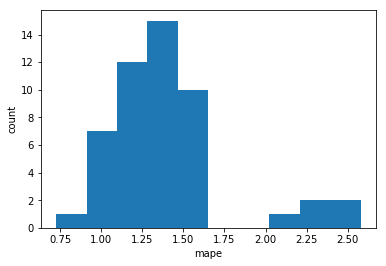

In [10]:
from matplotlib import pyplot as plt
plt.hist(ar)
plt.xlabel('mape')
plt.ylabel('count')
plt.show()

In [126]:
178.15936064720154
188.68681120872498
192.6354260444641
195.11175060272217
224.37290263175964

In [13]:
ar=[1.2037057487878013,
 0.9940908988606905,
 1.3337401084821803,
 1.186782251815374,
 1.2552579093151308]

In [117]:
173.3051197528839
168.94988250732422
175.94341945648193
175.7891173362732
175.96885442733765

175.96885442733765

In [28]:
204.363107919693
213.86773133277893
210.0688292980194


210.0688292980194

In [17]:
ar3=[1.8411824156211045,
 2.5574231290573257,
 2.2141223095043396,
 2.0242105917621513,
 2.1405732013449477]

In [36]:
72
103.99993085861206
95.59911012649536


95.59911012649536

In [18]:
aar=sum(ar)/len(ar)
aar1=sum(ar1)/len(ar1)
aar2=sum(ar2)/len(ar2)
aar3=sum(ar3)/len(ar3)

In [19]:
aar

1.1947153834522353

In [20]:
aar1

1.5279768626538632

In [21]:
aar2

1.744562401581117

In [22]:
aar3

2.1555023294579736

In [23]:
p=[aar3,aar2,aar1,aar]

In [24]:
p

[2.1555023294579736, 1.744562401581117, 1.5279768626538632, 1.1947153834522353]

In [126]:
ar4

[1.4612170216962528,
 1.4612170216962528,
 0.950375560604926,
 2.1781618758642005,
 1.0555948755454265,
 1.6202359603009582,
 1.0407667952835098,
 1.0284945908398413,
 1.2891856419027048,
 2.4057669660985077,
 1.276860069185699,
 1.4159519919866548,
 1.2912160175541265,
 1.3519005021873827,
 1.0485932040160773,
 1.3947970579352893,
 1.1906143013011898,
 0.9845542760324018]